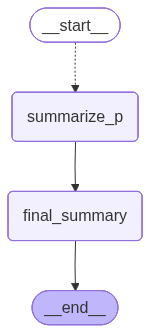

In [ ]:
# orchestrator.ipynb
from typing_extensions import TypedDict, Literal, Annotated
from typing import List
from langgraph.types import Send
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel
from operator import add

llm = init_chat_model("openai:gpt-4o-mini")

class State(TypedDict):
    document: str
    final_summary: str
    summaries: Annotated[list[dict], add]

def summarize_p(args):
    paragraph = args["paragraph"]
    index = args["index"]
    response = llm.invoke(
        f"Write a 3-sentence summary for this paragraph: {paragraph}",
    )
    return {
        "summaries": [
            {
                "summary": response.content,
                "index": index,
            }
        ],
    }

def dispatch_summarizers(state: State):
    chunks = state["document"].split("\n\n")
    return [
        Send("summarize_p", {"paragraph": chunk, "index": index})
        for index, chunk in enumerate(chunks)
    ]

def final_summary(state: State):
    response = llm.invoke(
        f"Using the following summaries, give me a final one {state["summaries"]}"
    )
    return {
        "final_summary": response.content,
    }

graph_builder = StateGraph(State)

graph_builder.add_node("summarize_p", summarize_p)
graph_builder.add_node("final_summary", final_summary)

graph_builder.add_conditional_edges(
    START,
    dispatch_summarizers,
    ["summarize_p"],
)

graph_builder.add_edge("summarize_p", "final_summary")
graph_builder.add_edge("final_summary", END)

graph = graph_builder.compile()

graph

In [2]:
with open("fed_transcript.md", "r", encoding="utf-8") as file:
    document = file.read()


for chunk in graph.stream(
    {"document": document},
    stream_mode="updates",
):
    print(chunk, "\n")

{'summarize_p': {'summaries': [{'summary': 'The committee welcomed a new member today and continues to work cohesively towards its dual mandate goals. They emphasize their commitment to maintaining independence. Beyond this, there are no additional updates to provide.', 'index': 25}]}} 

{'summarize_p': {'summaries': [{'summary': 'Currently, the effects observed are relatively minor but are anticipated to increase over time. It is expected that these effects will continue to grow throughout the year. Projections indicate this trend will extend into the following year as well.', 'index': 28}]}} 

{'summarize_p': {'summaries': [{'summary': 'Labor demand has weakened, leading to a slowdown in job creation. The current rate of job growth is insufficient to maintain the unemployment rate. As a result, it is likely that unemployment may increase if this trend continues.', 'index': 7}]}} 

{'summarize_p': {'summaries': [{'summary': 'The monetary policy actions are shaped by a dual mandate foc